![](https://raw.githubusercontent.com/quantumjot/btrack/main/docs/_static/btrack_logo.png)

# Example of using btrack to track cells in timelapse microscopy data

This notebook covers the following functionality:

* Load segmentation data and localize objects
* Load a table of localized objects 
* Run tracking algorithm
* Inspect the output
* Visualize the results in napari

In addition, we have an extensive tutorial of the cell tracking application as part of *napari*:  

https://napari.org/tutorials/tracking/cell_tracking.html

## Importing btrack and loading example datasets

In [ ]:
import btrack

from btrack import datasets

We can automatically download some example data to play with:

In [ ]:
CONFIG_FILE = datasets.cell_config()
SEGMENTATION_FILE = datasets.example_segmentation_file()
OBJECTS_FILE = datasets.example_track_objects_file()

## Finding objects to track

### Use case 1 - Objects from segmentation

These could be objects found using algorithms such as a UNet, *CellPose* or *StarDist*. We can use `scikit-image` to load the segmentation data, which returns a numpy array of dimensions (T, Y, X).

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import montage

In [ ]:
segmentation = imread(SEGMENTATION_FILE)

In [ ]:
segmentation.shape

### show the segmentation as a montage

In [ ]:
seq = montage(
    segmentation[::20, ::10, ::10], 
    grid_shape=(5, 5), 
    padding_width=10, 
    fill=255,
)

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(seq, cmap=plt.cm.gray)
ax.axis(False)
plt.show()

### localize the objects

Now we use a utility function to localise the objects in the segmentation. Note that we can also use scikit-image `regionprops` to calculate properties for each object, using the `properties` keyword:

In [ ]:
FEATURES = [
    "area", 
    "major_axis_length", 
    "minor_axis_length", 
    "orientation", 
    "solidity"
]

objects = btrack.utils.segmentation_to_objects(
    segmentation, 
    properties=tuple(FEATURES), 
    num_workers=4,  # parallelise this
)

We can also inspect each returned object to determine it's properties:

In [ ]:
objects[0]

## Running the tracking

In [ ]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure(CONFIG_FILE)
    tracker.max_search_radius = 50
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = FEATURES

    # append the objects to be tracked
    tracker.append(objects)

    # set the tracking volume
    tracker.volume=((0, 1600), (0, 1200))

    # track them (in interactive mode)
    tracker.track(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # store the tracks
    tracks = tracker.tracks
    
    # store the configuration
    cfg = tracker.configuration
    
    # export the track data 
    # tracker.export("tracks.h5", obj_type="obj_type_1")
    

## Inspecting the output

We can also inspect each returned track to determine it's properties:

In [ ]:
cell = tracks[1]

In [ ]:
cell

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
ax1.plot(cell.x, cell.y)
ax2.plot(cell.t, cell.x)
ax3.plot(cell.t, cell.y)
ax4.plot(cell.t, cell["area"])
plt.show()

## Visualising the data with napari

Finally, we an inspect the entire tracking output using *napari*:

In [ ]:
!pip install napari

In [ ]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    segmentation, 
    name="Segmentation",
    opacity=0.2,
)

# the track data from the tracker
viewer.add_tracks(
    data, 
    properties=properties, 
    graph=graph, 
    name="Tracks", 
    blending="translucent",
    visible=True,
)

In [ ]:
import numpy as np
import nd2
import btrack
from btrack import datasets
from skimage.io import imread
from skimage.util import montage
from skimage.measure import label
import matplotlib.pyplot as plt
from nd2reader import ND2Reader
import napari
import cv2
import tifffile


In [ ]:
# Define the path to your ND2 file
ND2_FILE = "/Applications/Oliveira Lab Projects/nd2-analyzer/datasets/nd2/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"  # Change this to the actual path

with ND2Reader(ND2_FILE) as nd2_file:
    # Read first frame as a test (to avoid loading entire file at once)
    # first_frame = nd2_file[0]
    # print(f"Frame shape: {first_frame.shape}")
    image_data = np.array(nd2_file)

# Check dataset properties
print(f"ND2 dataset shape: {image_data.shape}")  # (Frames, Height, Width)
print(f"Number of frames: {len(image_data)}")



In [ ]:
from segmentation.segmentation_models import SegmentationModels
import numpy as np

import os

# Set the path to your U-Net model weights (change this to the actual path)
os.environ["UNET_WEIGHTS"] = "/Users/user/Desktop/Amby-Oliveira Lab/training_checkpoints/delta_2_20_02_24_600eps"

# Initialize the segmentation model (Cellpose, U-Net, or CellSAM)
seg_model = SegmentationModels()
MODEL_TYPE = SegmentationModels.UNET  # Change to CELLPOSE, CELLSAM if needed

# Ensure segmentation model receives correct image format
segmented_images = []
for frame in image_data:
    frame = np.squeeze(frame)  # Remove extra dimensions (e.g., channels)

    if frame.ndim == 3:  
        frame = frame[0]  # Take only the first channel if multi-channel

    frame = frame.astype(np.float32)  # Convert to float32

    # Pass frame as a list
    segmented = seg_model.segment_images([frame], mode=MODEL_TYPE)
    
    # Append only the first element (since we passed a list)
    segmented_images.append(segmented[0])

segmented_images = np.array(segmented_images)  # Convert to NumPy array
print(f"Final segmented images shape: {segmented_images.shape}")


In [ ]:
import matplotlib.pyplot as plt

# Select a few sample frames to display
frames_to_show = [0, len(segmented_images) // 2, len(segmented_images) - 1]  # First, middle, last

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, idx in zip(axes, frames_to_show):
    ax.imshow(segmented_images[idx], cmap='gray')
    ax.set_title(f"Segmented Frame {idx}")
    ax.axis("off")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from skimage.util import montage
import numpy as np

# Create a montage of segmentation frames
def create_segmentation_montage(segmentation, grid_shape=(5, 5), step=1):
    """
    Create a montage of segmentation frames.
    
    Parameters:
    -----------
    segmentation : numpy.ndarray
        3D array of segmentation frames (time, height, width)
    grid_shape : tuple
        Number of rows and columns in the grid
    step : int
        Step size for selecting frames (to avoid showing every frame)
    
    Returns:
    --------
    numpy.ndarray
        Montage image
    """
    # Determine number of frames to show
    total_frames = min(grid_shape[0] * grid_shape[1], len(segmentation))
    
    # Select frames at regular intervals
    if len(segmentation) > total_frames:
        indices = np.linspace(0, len(segmentation)-1, total_frames, dtype=int)
    else:
        indices = range(0, len(segmentation), step)
        indices = indices[:total_frames]
    
    # Get selected frames
    selected_frames = segmentation[indices]
    
    # Convert to binary if not already
    binary_frames = (selected_frames > 0).astype(np.uint8) * 255
    
    # Create montage
    montage_image = montage(binary_frames, grid_shape=grid_shape, padding_width=10, fill=255)
    
    return montage_image

# Create and display the montage
grid_shape = (4, 5)  # Adjust rows and columns as needed
montage_img = create_segmentation_montage(segmented_images, grid_shape=grid_shape)

# Display the montage
plt.figure(figsize=(16, 16))
plt.imshow(montage_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('segmentation_montage.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Step 2: Define the features to extract (same as example)
FEATURES = [
    "area",
    "major_axis_length",
    "minor_axis_length",
    "orientation",
    "solidity"
]

# Step 3: Convert segmentation to btrack objects
objects = btrack.utils.segmentation_to_objects(
    segmented_images,
    properties=tuple(FEATURES),
    num_workers=4,
)

# Step 4: Configure and run the tracker
with btrack.BayesianTracker() as tracker:
    # Find the config file - you can use the example config or your own
    # If you want to use the example config:
    from btrack import datasets
    CONFIG_FILE = datasets.cell_config()
    
    # Or use your own config file path
    # CONFIG_FILE = '/path/to/your/btrack_config.json'
    
    # Configure the tracker
    tracker.configure(CONFIG_FILE)
    tracker.max_search_radius = 50  # Adjust based on cell movement
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = FEATURES
    
    # Append objects to tracker
    tracker.append(objects)
    
    # Set tracking volume based on your image dimensions
    h, w = segmented_images.shape[1:3]
    tracker.volume = ((0, w), (0, h))
    
    # Track them (with step_size for progress updates)
    tracker.track(step_size=100)
    
    # Optimize tracks (resolves track hypotheses)
    tracker.optimize()
    
    # Get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # Get raw tracks if needed
    tracks = tracker.tracks


In [ ]:
# Visualize with napari
import napari

viewer = napari.Viewer()

# Add segmentation image
viewer.add_image(
    segmented_images,
    name="Segmentation",
    opacity=0.2,
)
viewer.add_labels(segmented_images)
# Add tracks
viewer.add_tracks(
    data,
    properties=properties,
    graph=graph,
    name="Tracks",
    blending="translucent",
    visible=True,
)

napari.run()

In [ ]:
import pandas as pd
import numpy as np

# Convert tracks to a pandas DataFrame
def tracks_to_dataframe(tracks):
    data = []
    
    for track in tracks:
        # Get track data
        track_id = track.ID
        
        # Process each point in the track
        for i in range(len(track.t)):
            # Create a row for each timepoint
            row = {
                'ID': track_id,
                't': track.t[i],
                'x': track.x[i],
                'y': track.y[i],
                'z': 0.0,  # Most 2D tracking doesn't use z
                'parent': track.parent if hasattr(track, 'parent') else None,
                'root': track.root if hasattr(track, 'root') else None,
                'state': track.state if hasattr(track, 'state') else None,
                'generation': track.generation if hasattr(track, 'generation') else None
            }
            
            # Add any features the track might have
            if hasattr(track, 'features') and track.features is not None:
                for feature in FEATURES:
                    if i < len(track.features) and feature in track.features[i]:
                        row[feature] = track.features[i][feature]
            
            data.append(row)
    
    # Create DataFrame and sort by ID and t
    df = pd.DataFrame(data)
    df = df.sort_values(['ID', 't']).reset_index(drop=True)
    
    return df

# Create the DataFrame
tracking_df = tracks_to_dataframe(tracks)

# Display the table
print(tracking_df.head(30))

# Save to CSV (optional)
tracking_df.to_csv('tracking_results.csv', index=False)

In [ ]:
# Print statistics about the tracks
track_lengths = [len(track.x) for track in tracks]
avg_length = sum(track_lengths) / len(track_lengths)
max_length = max(track_lengths)

print(f"Total tracks: {len(tracks)}")
print(f"Average track length: {avg_length:.2f} frames")
print(f"Longest track: {max_length} frames")

# Count tracks by length
short_tracks = sum(1 for length in track_lengths if length < 5)
medium_tracks = sum(1 for length in track_lengths if 5 <= length < 15)
long_tracks = sum(1 for length in track_lengths if length >= 15)

print(f"Short tracks (<5 frames): {short_tracks}")
print(f"Medium tracks (5-14 frames): {medium_tracks}")
print(f"Long tracks (≥15 frames): {long_tracks}")

# Analyze division events if present
division_events = 0
for track in tracks:
    if hasattr(track, 'children') and track.children:
        division_events += 1

print(f"Cell division events: {division_events}")

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def create_lineage_tree(tracks):
    """
    Create a lineage tree visualization using NetworkX
    
    Parameters:
    -----------
    tracks : list
        List of track objects from btrack with lineage information
    """
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes for each track
    for track in tracks:
        track_id = track.ID
        
        # Get timing information
        if len(track.t) > 0:
            start_time = int(min(track.t))
            end_time = int(max(track.t))
            duration = end_time - start_time + 1
        else:
            start_time = 0
            end_time = 0
            duration = 0
            
        # Determine if this track divides
        has_children = hasattr(track, 'children') and track.children
        
        # Add node with attributes
        G.add_node(track_id, 
                  start_time=start_time,
                  end_time=end_time,
                  duration=duration,
                  divides=has_children)
    
    # Add edges for parent-child relationships
    for track in tracks:
        # If this track has children, add edges to them
        if hasattr(track, 'children') and track.children:
            for child_id in track.children:
                G.add_edge(track.ID, child_id)
    
    # Find all root nodes (tracks without parents)
    root_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]
    print(f"Found {len(root_nodes)} root tracks")
    
    # Find connected components (separate lineage trees)
    connected_components = list(nx.weakly_connected_components(G))
    print(f"Found {len(connected_components)} separate lineage trees")
    
    # For visualization, let's focus on the largest connected components
    largest_components = sorted(connected_components, key=len, reverse=True)
    
    # Select components to visualize (top 5 or fewer)
    top_components = largest_components[:min(5, len(largest_components))]
    
    # Create a subplot for each top component
    fig, axes = plt.subplots(1, len(top_components), figsize=(5*len(top_components), 8))
    if len(top_components) == 1:
        axes = [axes]  # Ensure axes is a list
    
    for i, component in enumerate(top_components):
        # Create subgraph for this component
        subgraph = G.subgraph(component)
        
        # Determine the root of this component
        component_roots = [n for n in subgraph.nodes() if subgraph.in_degree(n) == 0]
        if not component_roots:
            print(f"Warning: Component {i} has no root nodes")
            continue
            
        # Create a hierarchical layout - root at top, flowing downward
        pos = {}
        
        # Use hierarchical layout
        try:
            # Try to use graphviz for layout if available
            pos = nx.nx_agraph.graphviz_layout(subgraph, prog='dot')
        except:
            # Fall back to a custom hierarchical layout
            pos = hierarchy_pos(subgraph, component_roots[0])
        
        # Draw the lineage tree
        ax = axes[i]
        
        # Draw nodes with size based on duration and color based on division
        node_sizes = [100 + subgraph.nodes[n]['duration'] * 10 for n in subgraph.nodes()]
        node_colors = ['red' if subgraph.nodes[n]['divides'] else 'blue' 
                      for n in subgraph.nodes()]
        
        nx.draw_networkx_nodes(subgraph, pos, 
                             node_size=node_sizes,
                             node_color=node_colors,
                             alpha=0.8,
                             ax=ax)
        
        # Draw edges
        nx.draw_networkx_edges(subgraph, pos,
                             edge_color='black',
                             arrows=True,
                             arrowsize=15,
                             ax=ax)
        
        # Draw labels
        nx.draw_networkx_labels(subgraph, pos,
                              font_size=8,
                              ax=ax)
        
        # Set title and turn off axis
        ax.set_title(f"Lineage Tree {i+1}\n({len(component)} cells)")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('lineage_trees.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return G

# Helper function for hierarchical layout
def hierarchy_pos(G, root, width=1., vert_gap=0.1, vert_loc=0, xcenter=0.5):
    """
    If the graph is a tree this will return the positions to plot it.
    G: the graph
    root: the root node
    width: horizontal space allocated for this branch
    vert_gap: gap between levels
    vert_loc: vertical location of root
    xcenter: horizontal location of root
    """
    def _hierarchy_pos(G, root, width=1., vert_gap=0.1, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=[]):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if parent is not None:
            if root in children:
                children.remove(parent)
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, 
                                    vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                    parent=root, parsed=parsed)
        return pos
    
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

# Create the lineage tree visualization
lineage_graph = create_lineage_tree(tracks)

In [ ]:
# First, let's examine one of your tracks to understand its structure
sample_track = tracks[0]
print("Sample track ID:", sample_track.ID)
print("Sample track attributes:", dir(sample_track))
print("Has children attribute:", hasattr(sample_track, 'children'))
print("Has parent attribute:", hasattr(sample_track, 'parent'))

# Check if we have division events as you reported
division_count = sum(1 for track in tracks if hasattr(track, 'children') and track.children)
print(f"Division events found in tracks: {division_count}")
print(f"This should match your reported count: 323")

# Now modify the lineage tree visualization to work with your data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def create_lineage_tree_from_tracks(tracks):
    """
    Create a lineage tree visualization specifically for your tracked cells
    """
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes for each track with IDs printed for verification
    for i, track in enumerate(tracks):
        track_id = track.ID
        if i < 5:  # Print first 5 for verification
            print(f"Adding track ID: {track_id}")
        
        # Add node
        G.add_node(track_id)
    
    # Add edges for parent-child relationships
    edges_added = 0
    for track in tracks:
        if hasattr(track, 'children') and track.children:
            children = track.children
            if not isinstance(children, list):
                children = [children]  # Convert to list if it's a single value
                
            for child_id in children:
                G.add_edge(track.ID, child_id)
                edges_added += 1
                if edges_added <= 5:  # Print first 5 for verification
                    print(f"Added edge: {track.ID} -> {child_id}")
    
    print(f"Added {edges_added} parent-child relationships")
    
    # Check if we have a valid graph for visualization
    if len(G.edges()) == 0:
        print("ERROR: No parent-child relationships found in the graph.")
        print("Cannot create lineage trees without relationships.")
        return G
    
    # Continue with visualization (rest of your code)
    # Find root nodes and connected components
    root_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]
    print(f"Found {len(root_nodes)} root tracks")
    
    connected_components = list(nx.weakly_connected_components(G))
    print(f"Found {len(connected_components)} separate lineage trees")
    
    # Get the sizes of the largest components
    largest_components = sorted(connected_components, key=len, reverse=True)
    largest_sizes = [len(comp) for comp in largest_components[:5]]
    print(f"Largest lineage tree sizes: {largest_sizes}")
    
    # Visualize top components
    top_components = largest_components[:min(5, len(largest_components))]
    
    fig, axes = plt.subplots(1, len(top_components), figsize=(5*len(top_components), 8))
    if len(top_components) == 1:
        axes = [axes]  # Ensure axes is a list
    
    for i, component in enumerate(top_components):
        # Create subgraph for this component
        subgraph = G.subgraph(component)
        
        # Find roots in this component
        component_roots = [n for n in subgraph.nodes() if subgraph.in_degree(n) == 0]
        if not component_roots:
            print(f"Warning: Component {i} has no root nodes")
            continue
        
        # Create a layout
        try:
            # Try to use spring layout which doesn't require tree structure
            pos = nx.spring_layout(subgraph, seed=42)
            
            # Draw the graph
            ax = axes[i]
            nx.draw_networkx_nodes(subgraph, pos, 
                                node_size=100,
                                node_color='blue',
                                alpha=0.8,
                                ax=ax)
            
            nx.draw_networkx_edges(subgraph, pos,
                                edge_color='black',
                                arrows=True,
                                ax=ax)
            
            nx.draw_networkx_labels(subgraph, pos,
                                font_size=8,
                                ax=ax)
            
            ax.set_title(f"Lineage Tree {i+1}\n({len(component)} cells)")
            ax.axis('off')
        except Exception as e:
            print(f"Error visualizing component {i}: {e}")
    
    plt.tight_layout()
    plt.savefig('lineage_trees_from_tracking.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return G

# Create the lineage tree visualization from your data
lineage_graph = create_lineage_tree_from_tracks(tracks)

# Challenge 1: Chamber Alignment

## Objective
Align raw microscopy images that have stage jitter/drift using the registration module.

## Task
1. Load raw ND2 data
2. Apply image registration to correct for stage drift
3. Visualize the before/after alignment
4. Compare aligned vs unaligned image sequences

## Expected Output
- Aligned image stack
- Side-by-side comparison showing improvement
- Overlay visualization demonstrating alignment quality

In [ ]:
!pip install nd2reader

In [ ]:
# Import registration utilities
import sys
sys.path.append('/Applications/Oliveira Lab Projects/nd2-analyzer/PARTAKER/partaker/src')

from nd2_analyzer.utils.registration import register_images
from nd2reader import ND2Reader
import numpy as np
import matplotlib.pyplot as plt

# Load raw ND2 file with stage jitter
ND2_FILE_PATH = "/Volumes/AMBY_SSD/datasets/nd2/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"

# Read the ND2 file
with ND2Reader(ND2_FILE_PATH) as nd2_file:
    raw_images = np.array(nd2_file)

print(f"Loaded {raw_images.shape[0]} frames")
print(f"Image dimensions: {raw_images.shape[1]}x{raw_images.shape[2]}")

# Convert to proper format if needed (squeeze to 2D if multi-channel)
if raw_images.ndim == 4:
    raw_images = raw_images.squeeze()

print(f"Final shape for registration: {raw_images.shape}")

In [ ]:
# Perform image registration to remove stage jitter
print("Running image registration...")
registration_result = register_images(
    raw_images,
    iteration_depth=1000,  # Search depth for alignment algorithm
    return_images=True,    # Return the aligned images
    verbose=True
)

# Get the aligned images and offsets
aligned_images = np.array([raw_images[0]] + registration_result.registered_images)
offsets = registration_result.offsets

print(f"\nRegistration complete!")
print(f"Computed {len(offsets)} offset pairs")
print(f"Aligned images shape: {aligned_images.shape}")

# Display offset statistics
x_offsets = offsets[:, 0]
y_offsets = offsets[:, 1]
print(f"\nOffset statistics:")
print(f"X-offsets - Mean: {np.mean(x_offsets):.2f}, Std: {np.std(x_offsets):.2f}, Range: [{np.min(x_offsets)}, {np.max(x_offsets)}]")
print(f"Y-offsets - Mean: {np.mean(y_offsets):.2f}, Std: {np.std(y_offsets):.2f}, Range: [{np.min(y_offsets)}, {np.max(y_offsets)}]")

In [ ]:
# Visualize offset trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot X and Y offsets over time
frames = np.arange(len(offsets))
ax1.plot(frames, x_offsets, 'b-', label='X offset', linewidth=2)
ax1.set_xlabel('Frame')
ax1.set_ylabel('X offset (pixels)')
ax1.set_title('X Displacement Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(frames, y_offsets, 'r-', label='Y offset', linewidth=2)
ax2.set_xlabel('Frame')
ax2.set_ylabel('Y offset (pixels)')
ax2.set_title('Y Displacement Over Time')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot trajectory in 2D space
ax3.plot(x_offsets, y_offsets, 'go-', markersize=4, linewidth=1, alpha=0.6)
ax3.scatter(x_offsets[0], y_offsets[0], c='green', s=100, marker='o', label='Start', zorder=5)
ax3.scatter(x_offsets[-1], y_offsets[-1], c='red', s=100, marker='s', label='End', zorder=5)
ax3.set_xlabel('X offset (pixels)')
ax3.set_ylabel('Y offset (pixels)')
ax3.set_title('Stage Drift Trajectory')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.axis('equal')

plt.tight_layout()
plt.savefig('chamber_alignment_offsets.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Side-by-side comparison of before/after alignment for selected frames
frame_indices = [0, len(raw_images)//3, 2*len(raw_images)//3, -1]  # First, two middle, last

fig, axes = plt.subplots(2, len(frame_indices), figsize=(20, 10))

for i, idx in enumerate(frame_indices):
    # Before alignment
    axes[0, i].imshow(raw_images[idx], cmap='gray')
    axes[0, i].set_title(f'Before - Frame {idx}')
    axes[0, i].axis('off')

    # After alignment
    axes[1, i].imshow(aligned_images[idx], cmap='gray')
    axes[1, i].set_title(f'After - Frame {idx}')
    axes[1, i].axis('off')

# Row labels
axes[0, 0].set_ylabel('Raw (Unaligned)', fontsize=12, rotation=0, ha='right', va='center')
axes[1, 0].set_ylabel('Aligned', fontsize=12, rotation=0, ha='right', va='center')

plt.tight_layout()
plt.savefig('chamber_alignment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Overlay visualization - comparing alignment quality
# Create RGB composites where first frame is green and last frame is magenta
# Good alignment = gray (overlap), poor alignment = colored edges

def create_overlay_comparison(image1, image2, normalize=True):
    """Create RGB overlay where image1=green, image2=magenta"""
    if normalize:
        img1 = (image1 - image1.min()) / (image1.max() - image1.min())
        img2 = (image2 - image2.min()) / (image2.max() - image2.min())
    else:
        img1 = image1
        img2 = image2

    # Create RGB image: Red and Blue from img2, Green from img1
    overlay = np.zeros((*img1.shape, 3))
    overlay[:, :, 0] = img2  # Red channel
    overlay[:, :, 1] = img1  # Green channel
    overlay[:, :, 2] = img2  # Blue channel

    return overlay

# Compare first and last frames
first_frame = 0
last_frame = -1

# Before alignment overlay
raw_overlay = create_overlay_comparison(raw_images[first_frame], raw_images[last_frame])

# After alignment overlay
aligned_overlay = create_overlay_comparison(aligned_images[first_frame], aligned_images[last_frame])

# Display overlays
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(raw_overlay)
ax1.set_title(f'Before Alignment\nFrame {first_frame} (Green) + Frame {len(raw_images)-1} (Magenta)',
              fontsize=14)
ax1.axis('off')

ax2.imshow(aligned_overlay)
ax2.set_title(f'After Alignment\nFrame {first_frame} (Green) + Frame {len(aligned_images)-1} (Magenta)',
              fontsize=14)
ax2.axis('off')

# Add explanation
fig.text(0.5, 0.02,
         'Gray/White = Perfect alignment | Green/Magenta edges = Misalignment',
         ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.savefig('chamber_alignment_overlay.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Optional: Save aligned images for further analysis or create a video
import tifffile

# Save aligned images as TIFF stack
output_file = 'aligned_images.tif'
tifffile.imwrite(output_file, aligned_images.astype(np.uint16))
print(f"Saved aligned images to: {output_file}")

# Create a simple animation comparison (if desired)
# You can use matplotlib.animation or imageio to create GIFs
try:
    import imageio

    # Create GIF comparing before/after
    # Normalize for better visualization
    def normalize_frame(frame):
        return ((frame - frame.min()) / (frame.max() - frame.min()) * 255).astype(np.uint8)

    # Select subset of frames for GIF (every 2nd frame to keep file size manageable)
    step = 2
    frames_subset = range(0, len(raw_images), step)

    # Create side-by-side comparison frames
    comparison_frames = []
    for idx in frames_subset:
        # Normalize
        raw_norm = normalize_frame(raw_images[idx])
        aligned_norm = normalize_frame(aligned_images[idx])

        # Stack horizontally
        combined = np.hstack([raw_norm, aligned_norm])
        comparison_frames.append(combined)

    # Save as GIF
    imageio.mimsave('alignment_comparison.gif', comparison_frames, duration=0.1)
    print("Saved comparison GIF to: alignment_comparison.gif")

except ImportError:
    print("imageio not installed. Skipping GIF creation.")
    print("Install with: pip install imageio")

print("\nChallenge 1 Complete!")

## Challenge 1 Summary

**What you accomplished:**
1. ✅ Loaded raw microscopy data with stage drift/jitter
2. ✅ Applied image registration using the MAE (Mean Absolute Error) tree search algorithm
3. ✅ Computed optimal X,Y offsets for each frame
4. ✅ Created aligned image stack
5. ✅ Visualized drift trajectory and alignment quality
6. ✅ Generated comparison plots and overlays

**Key Metrics to Report:**
- Total frames processed
- Offset statistics (mean, std, range)
- Alignment quality (visual assessment)

**Bonus Tasks (if time permits):**
- Try different `iteration_depth` values and compare results
- Measure alignment quality quantitatively (e.g., correlation between first and last frames)
- Create a video showing before/after alignment
- Test on different ND2 files with varying drift patterns

---

# Challenge 3: Cell Tracking

## Objective
Track individual cells across 10 frames from segmented microscopy images.

## Task
1. Load segmented images (10 frames)
2. Localize cells in each frame using region properties
3. Run btrack to link cells across frames
4. Visualize tracks with unique colors/IDs
5. Create tracked image outputs showing cell trajectories

## Expected Output
- Track statistics (number of tracks, average track length)
- Visualization of cell tracks overlaid on images
- Track data exported to CSV
- Color-coded tracking visualization

## Skills Learned
- Object detection from segmented images
- Multi-object tracking algorithms
- Track visualization and analysis

In [ ]:
# Import required libraries
import btrack
from btrack import datasets
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import pandas as pd

# Load YOUR segmented images (first 10 frames for this challenge)
print("Loading segmented images from your dataset...")

# Option 1: If segmented_images already exists from earlier cells
try:
    if 'segmented_images' in locals() or 'segmented_images' in globals():
        tracking_images = segmented_images[:10].copy()
        print(f"✓ Using segmented images from earlier: {tracking_images.shape}")
    else:
        raise NameError("segmented_images not found")
except:
    # Option 2: Segment fresh from ND2 file
    print("Segmented images not found. Loading and segmenting from ND2 file...")
    from nd2reader import ND2Reader
    from nd2_analyzer.analysis.segmentation import SegmentationModels
    import os
    
    # Load raw data
    ND2_FILE = "/Applications/Oliveira Lab Projects/nd2-analyzer/datasets/nd2/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"
    with ND2Reader(ND2_FILE) as nd2_file:
        raw_images = np.array(nd2_file[:10])  # First 10 frames only
    
    # Set up segmentation model
    os.environ["UNET_WEIGHTS"] = "/Users/user/Desktop/Amby-Oliveira Lab/training_checkpoints/delta_2_20_02_24_600eps"
    seg_model = SegmentationModels()
    
    # Segment images
    tracking_images = []
    for frame in raw_images:
        frame = np.squeeze(frame).astype(np.float32)
        if frame.ndim == 3:
            frame = frame[0]
        segmented = seg_model.segment_images([frame], mode=SegmentationModels.UNET)
        tracking_images.append(segmented[0])
    
    tracking_images = np.array(tracking_images)
    print(f"✓ Segmented {len(tracking_images)} frames: {tracking_images.shape}")

# Display sample frames
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(tracking_images[i], cmap='gray')
    ax.set_title(f'Frame {i}')
    ax.axis('off')
plt.suptitle('Your Segmented Data - 10 Frames for Tracking', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Ready to track cells across {len(tracking_images)} frames from YOUR dataset!")

In [ ]:
# Extract cell features from segmented images
print("Extracting cell objects from segmentation...")

# Define features to extract for tracking
TRACKING_FEATURES = [
    "area",
    "major_axis_length",
    "minor_axis_length",
    "orientation",
    "solidity"
]

# Use btrack utility to convert segmentation to objects
tracking_objects = btrack.utils.segmentation_to_objects(
    tracking_images,
    properties=tuple(TRACKING_FEATURES),
    num_workers=4
)

print(f"Found {len(tracking_objects)} objects across {len(tracking_images)} frames")
print(f"\nSample object properties:")
print(tracking_objects[0])

# Count objects per frame
objects_per_frame = {}
for obj in tracking_objects:
    frame = int(obj['t'])
    objects_per_frame[frame] = objects_per_frame.get(frame, 0) + 1

print(f"\nObjects detected per frame:")
for frame, count in sorted(objects_per_frame.items()):
    print(f"  Frame {frame}: {count} cells")

In [ ]:
# Run the tracking algorithm
print("Running cell tracking with btrack...")

# Initialize tracker
with btrack.BayesianTracker() as tracker:
    # Configure tracker with cell config
    CONFIG_FILE = datasets.cell_config()
    tracker.configure(CONFIG_FILE)
    
    # Set tracking parameters
    tracker.max_search_radius = 50
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = TRACKING_FEATURES
    
    # Add objects to tracker
    tracker.append(tracking_objects)
    
    # Set tracking volume based on image dimensions
    h, w = tracking_images.shape[1:3]
    tracker.volume = ((0, w), (0, h))
    
    # Perform tracking
    tracker.track()
    
    # Optimize tracks (resolve ambiguities)
    tracker.optimize()
    
    # Get results
    cell_tracks = tracker.tracks
    track_data, track_properties, track_graph = tracker.to_napari()

print(f"Tracking complete!")
print(f"Found {len(cell_tracks)} tracks")

# Analyze track statistics
track_lengths = [len(track.t) for track in cell_tracks]
print(f"\nTrack Statistics:")
print(f"  Total tracks: {len(cell_tracks)}")
print(f"  Average track length: {np.mean(track_lengths):.2f} frames")
print(f"  Longest track: {max(track_lengths)} frames")
print(f"  Shortest track: {min(track_lengths)} frames")

# Histogram of track lengths
plt.figure(figsize=(10, 5))
plt.hist(track_lengths, bins=range(1, max(track_lengths)+2), edgecolor='black', alpha=0.7)
plt.xlabel('Track Length (frames)')
plt.ylabel('Number of Tracks')
plt.title('Distribution of Track Lengths')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Visualize tracks overlaid on images
import matplotlib.patches as patches
from matplotlib import cm

print("Creating tracked image visualizations...")

# Generate unique colors for each track
n_tracks = len(cell_tracks)
colors = cm.rainbow(np.linspace(0, 1, n_tracks))

# Create visualizations for each frame
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for frame_idx in range(len(tracking_images)):
    ax = axes[frame_idx]
    
    # Display base image
    ax.imshow(tracking_images[frame_idx], cmap='gray', alpha=0.5)
    
    # Overlay tracks
    for track_idx, track in enumerate(cell_tracks):
        # Find points in this frame
        frame_mask = track.t == frame_idx
        if np.any(frame_mask):
            x_pos = track.x[frame_mask]
            y_pos = track.y[frame_mask]
            
            # Plot current position
            ax.plot(x_pos, y_pos, 'o', color=colors[track_idx], 
                   markersize=8, markeredgecolor='white', markeredgewidth=1)
            
            # Add track ID label
            if len(x_pos) > 0:
                ax.text(x_pos[0], y_pos[0], str(track.ID), 
                       fontsize=6, color='white', 
                       bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[track_idx], alpha=0.7))
            
            # Draw trajectory up to this frame
            trajectory_mask = track.t <= frame_idx
            if np.sum(trajectory_mask) > 1:
                ax.plot(track.x[trajectory_mask], track.y[trajectory_mask], 
                       '-', color=colors[track_idx], linewidth=1.5, alpha=0.6)
    
    ax.set_title(f'Frame {frame_idx}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig('cell_tracking_overlay.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization complete!")

In [ ]:
# Export track data to CSV
print("Exporting track data...")

# Convert tracks to DataFrame
track_data_list = []

for track in cell_tracks:
    track_id = track.ID
    
    for i in range(len(track.t)):
        row = {
            'track_id': track_id,
            'frame': int(track.t[i]),
            'x': track.x[i],
            'y': track.y[i],
            'area': track.properties.get('area', [None]*len(track.t))[i] if hasattr(track, 'properties') else None
        }
        track_data_list.append(row)

# Create DataFrame
tracks_df = pd.DataFrame(track_data_list)
tracks_df = tracks_df.sort_values(['track_id', 'frame']).reset_index(drop=True)

# Save to CSV
csv_filename = 'cell_tracks_10frames.csv'
tracks_df.to_csv(csv_filename, index=False)
print(f"Saved track data to: {csv_filename}")

# Display sample
print(f"\nSample track data (first 20 rows):")
print(tracks_df.head(20))

# Summary statistics
print(f"\nDataFrame shape: {tracks_df.shape}")
print(f"Unique tracks: {tracks_df['track_id'].nunique()}")
print(f"Frames covered: {tracks_df['frame'].min()} to {tracks_df['frame'].max()}")

In [ ]:
# Visualize individual track trajectories
print("Plotting individual cell trajectories...")

# Select tracks that span at least 5 frames for better visualization
long_tracks = [track for track in cell_tracks if len(track.t) >= 5]
n_display = min(12, len(long_tracks))  # Display up to 12 tracks

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(n_display):
    ax = axes[i]
    track = long_tracks[i]
    
    # Plot trajectory
    ax.plot(track.x, track.y, 'o-', linewidth=2, markersize=6, alpha=0.7)
    
    # Mark start and end points
    ax.plot(track.x[0], track.y[0], 'go', markersize=12, label='Start', markeredgecolor='darkgreen', markeredgewidth=2)
    ax.plot(track.x[-1], track.y[-1], 'rs', markersize=12, label='End', markeredgecolor='darkred', markeredgewidth=2)
    
    # Add frame numbers
    for j, (x, y, t) in enumerate(zip(track.x, track.y, track.t)):
        if j % 2 == 0:  # Label every other point to avoid clutter
            ax.text(x, y, str(int(t)), fontsize=8, ha='center', va='bottom')
    
    ax.set_title(f'Track ID: {track.ID} ({len(track.t)} frames)', fontsize=10)
    ax.set_xlabel('X position (pixels)')
    ax.set_ylabel('Y position (pixels)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

# Hide unused subplots
for i in range(n_display, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('individual_cell_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Displayed {n_display} cell trajectories")

## Challenge 3 Summary

**What you accomplished:**
1. ✅ Loaded and displayed segmented images (10 frames)
2. ✅ Extracted cell objects with region properties
3. ✅ Configured and ran btrack for multi-object tracking
4. ✅ Generated track statistics and histograms
5. ✅ Created color-coded track visualizations
6. ✅ Exported track data to CSV
7. ✅ Plotted individual cell trajectories

**Key Metrics to Report:**
- Total number of tracks detected
- Average track length
- Objects detected per frame
- Track quality (how many tracks span all 10 frames?)

**Bonus Tasks (if time permits):**
- Calculate cell velocities from track data
- Identify cells that divide or merge
- Compare tracking with different `max_search_radius` values
- Create an animated GIF showing tracks over time
- Analyze cell movement patterns (random vs directional)

---

# Challenge 4: Bacterial Lineage Analysis

## 📋 Task Overview

You are a computational biologist analyzing time-lapse microscopy data of bacterial cell populations. Your lab has already performed image segmentation and cell tracking on 37 time-series images of E. coli bacteria. Your task is to analyze the lineage relationships between cells, identify the longest family trees, and present your findings with beautiful visualizations.

---

## 🎯 Your Mission

**Primary Objective:** Identify and visualize the 5 longest bacterial lineages in the provided dataset.

- A **lineage** is defined as a complete family tree starting from a **founder cell** (a cell with no parent) and including all its descendants through multiple generations of cell divisions.
- **Lineage length** is measured by the **number of generations (depth of the tree)**, not the total number of cells in the lineage.

---

## 📊 Dataset Description

You will receive a CSV file (`lineage_data.csv`) containing tracking and morphology data for all detected bacterial cells across 37 time-series frames.

**Dataset Path:**
```
/Applications/Oliveira Lab Projects/nd2-analyzer/PARTAKER/partaker/notebooks/lineage_data.csv
```

### Data Columns:

| Column           | Type  | Description                                                       |
|------------------|-------|-------------------------------------------------------------------|
| track_id         | int   | Unique identifier for each cell (1-2282)                          |
| parent_id        | int   | Track ID of the parent cell (0 = founder cell with no parent)     |
| start_frame      | int   | Time frame when cell first appears (0-36)                         |
| end_frame        | int   | Time frame when cell last appears (0-36)                          |
| morphology_class | str   | Cell shape classification: "elongated", "rod", "sphere", "curved" |
| area             | float | Cell area in pixels²                                              |
| length           | float | Cell length in pixels                                             |
| width            | float | Cell width in pixels                                              |
| centroid_x       | float | X-coordinate of cell center                                       |
| centroid_y       | float | Y-coordinate of cell center                                       |

### Example Data:

```
track_id,parent_id,start_frame,end_frame,morphology_class,area,length,width,centroid_x,centroid_y
1,0,0,2,elongated,450.5,18.5,3.2,512.3,768.9
15,1,2,4,elongated,420.3,17.8,3.1,515.7,771.2
16,1,2,4,rod,380.2,15.2,3.4,508.9,766.5
42,15,4,4,elongated,410.8,18.1,3.0,518.4,773.8
```

**Interpretation:**
- Cell 1 is a founder cell (parent_id=0), appears in frames 0-2, elongated shape
- Cell 1 divides in frame 2, producing two daughter cells: 15 and 16
- Cell 15 divides in frame 4, producing cell 42 (and possibly others)
- This creates a 3-generation lineage: 1 → 15 → 42

---

## 📝 Detailed Requirements

### Part 1: Data Processing & Tree Construction (40%)

1. **Load and validate the dataset**
   - Read the CSV file
   - Check for data integrity
   - Handle any edge cases (missing values, orphaned cells, etc.)

2. **Build lineage tree structures**
   - Identify all founder cells (parent_id == 0)
   - Construct parent-child relationships
   - Create separate tree structures for each lineage
   - Use appropriate data structures (recommended: graphs, trees, or nested dictionaries)

3. **Calculate lineage depth**
   - For each lineage, determine the number of generations
   - A founder cell alone = 1 generation
   - Founder → child = 2 generations
   - Founder → child → grandchild = 3 generations, etc.

4. **Identify the 5 longest lineages**
   - Rank all lineages by depth (number of generations)
   - Select the top 5
   - If there are ties, use total number of descendants as tiebreaker
   - If still tied, use the earliest founder cell (lowest track_id)

### Part 2: Visualization (30%)

Create **5 separate tree visualizations**, one for each of the longest lineages.

**Required elements for each visualization:**
- Clear hierarchical layout showing parent-child relationships
- Nodes representing individual cells
- Node labels showing track_id
- **Color-coding by morphology class:**
  - Elongated = Blue
  - Rod = Green  
  - Sphere = Orange
  - Curved = Purple
- Generation levels clearly visible
- Title indicating lineage rank and statistics
- Legend explaining colors

**Recommended libraries:** networkx, matplotlib, plotly, graphviz, pygraphviz

**Bonus points for:**
- Interactive visualizations
- Node size proportional to cell area
- Animation showing lineage growth over time
- Creative and aesthetically pleasing layouts

---

## Expected Output

- Summary statistics (total lineages, depth distribution)
- Table showing the top 5 longest lineages with their properties
- 5 high-quality lineage tree visualizations
- Clear documentation of tiebreaker logic used

---

**Good luck! 🔬🦠**

In [1]:
# Part 1: Load and Validate the Dataset
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

print("="*60)
print("CHALLENGE 4: BACTERIAL LINEAGE ANALYSIS")
print("="*60)

# Load the CSV file
csv_path = '/Applications/Oliveira Lab Projects/nd2-analyzer/PARTAKER/partaker/notebooks/lineage_data.csv'
print(f"\n📁 Loading data from: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"✓ Successfully loaded {len(df)} cells")
except FileNotFoundError:
    print(f"❌ ERROR: File '{csv_path}' not found!")
    print("Please make sure the CSV file is in the correct location.")
    raise

# Display basic info
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"   Columns: {list(df.columns)}")

# Validate required columns
required_columns = ['track_id', 'parent_id', 'start_frame', 'end_frame', 
                   'morphology_class', 'area', 'length', 'width', 
                   'centroid_x', 'centroid_y']

missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"❌ ERROR: Missing required columns: {missing_columns}")
    raise ValueError(f"Dataset is missing columns: {missing_columns}")
else:
    print(f"✓ All required columns present")

# Data validation
print(f"\n🔍 Data Validation:")

# Check for missing values
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    print(f"⚠️  Missing values detected:")
    for col, count in missing_counts[missing_counts > 0].items():
        print(f"   - {col}: {count} missing")
else:
    print(f"✓ No missing values")

# Check track_id uniqueness
if df['track_id'].nunique() == len(df):
    print(f"✓ All track_ids are unique")
else:
    print(f"⚠️  Duplicate track_ids found: {len(df) - df['track_id'].nunique()} duplicates")

# Check parent_id validity
invalid_parents = df[(df['parent_id'] != 0) & ~df['parent_id'].isin(df['track_id'])]
if len(invalid_parents) > 0:
    print(f"⚠️  {len(invalid_parents)} cells have invalid parent_ids (orphaned cells)")
    print(f"   These cells will be treated as founder cells")
else:
    print(f"✓ All parent_ids are valid")

# Check morphology classes
morphology_classes = df['morphology_class'].unique()
expected_classes = {'elongated', 'rod', 'sphere', 'curved'}
print(f"✓ Morphology classes found: {sorted(morphology_classes)}")
unexpected = set(morphology_classes) - expected_classes
if unexpected:
    print(f"⚠️  Unexpected morphology classes: {unexpected}")

# Frame range
print(f"\n📅 Frame Range: {df['start_frame'].min()} to {df['end_frame'].max()}")

# Summary statistics
print(f"\n📈 Summary Statistics:")
print(f"   Total cells: {len(df)}")
print(f"   Founder cells (parent_id=0): {(df['parent_id'] == 0).sum()}")
print(f"   Non-founder cells: {(df['parent_id'] != 0).sum()}")
print(f"   Average cell area: {df['area'].mean():.2f} pixels²")
print(f"   Average cell length: {df['length'].mean():.2f} pixels")

# Display sample data
print(f"\n📋 Sample Data (first 10 rows):")
print(df.head(10).to_string(index=False))

print(f"\n✓ Data loading and validation complete!")
print("="*60)

CHALLENGE 4: BACTERIAL LINEAGE ANALYSIS

📁 Loading data from: /Applications/Oliveira Lab Projects/nd2-analyzer/PARTAKER/partaker/notebooks/lineage_data.csv
✓ Successfully loaded 2282 cells

📊 Dataset Shape: (2282, 10)
   Columns: ['track_id', 'parent_id', 'start_frame', 'end_frame', 'morphology_class', 'area', 'length', 'width', 'centroid_x', 'centroid_y']
✓ All required columns present

🔍 Data Validation:
✓ No missing values
✓ All track_ids are unique
✓ All parent_ids are valid
✓ Morphology classes found: ['curved', 'elongated', 'rod', 'sphere']

📅 Frame Range: 0 to 36

📈 Summary Statistics:
   Total cells: 2282
   Founder cells (parent_id=0): 1884
   Non-founder cells: 398
   Average cell area: 1177.31 pixels²
   Average cell length: 86.00 pixels

📋 Sample Data (first 10 rows):
 track_id  parent_id  start_frame  end_frame morphology_class    area  length  width  centroid_x  centroid_y
        1          0            0         17              rod  512.43  295.86   2.00     1128.70    

In [2]:
# Part 2: Build Lineage Trees and Calculate Depth

print("\n" + "="*60)
print("BUILDING LINEAGE TREES")
print("="*60)

# Create a directed graph to represent lineage relationships
G = nx.DiGraph()

# Add all cells as nodes with their attributes
for _, row in df.iterrows():
    G.add_node(row['track_id'],
              parent_id=row['parent_id'],
              start_frame=row['start_frame'],
              end_frame=row['end_frame'],
              morphology_class=row['morphology_class'],
              area=row['area'],
              length=row['length'],
              width=row['width'],
              centroid_x=row['centroid_x'],
              centroid_y=row['centroid_y'])

# Add edges for parent-child relationships
# Exclude parent_id=0 (founder cells have no parent)
edges_added = 0
for _, row in df.iterrows():
    if row['parent_id'] != 0:
        # Check if parent exists in the graph
        if row['parent_id'] in G.nodes():
            G.add_edge(row['parent_id'], row['track_id'])
            edges_added += 1

print(f"\n🔗 Graph Construction:")
print(f"   Nodes (cells): {G.number_of_nodes()}")
print(f"   Edges (parent→child): {edges_added}")

# Identify founder cells (cells with no parent or parent_id=0)
founder_cells = [node for node in G.nodes() 
                if G.in_degree(node) == 0]
print(f"   Founder cells: {len(founder_cells)}")

# Get weakly connected components (separate lineage trees)
connected_components = list(nx.weakly_connected_components(G))
num_lineages = len(connected_components)
print(f"   Separate lineages: {num_lineages}")

# Function to calculate depth (number of generations) for a lineage
def calculate_lineage_depth(graph, root_node):
    """
    Calculate the depth of a lineage tree (number of generations).
    Generation count starts at 1 for the founder cell.
    """
    try:
        # Use BFS to find the longest path from root
        # We need to traverse all descendants and find maximum depth
        max_depth = 1  # Founder cell is generation 1
        
        # Get all descendants
        descendants = nx.descendants(graph, root_node)
        
        if not descendants:
            return 1  # Only the founder, so depth = 1
        
        # For each descendant, calculate its depth from root
        for desc in descendants:
            try:
                # Find shortest path (in terms of edges) from root to descendant
                # Add 1 because we count generations (nodes), not edges
                path_length = nx.shortest_path_length(graph, root_node, desc)
                depth = path_length + 1  # +1 to convert edges to generations
                max_depth = max(max_depth, depth)
            except nx.NetworkXNoPath:
                continue
        
        return max_depth
    except:
        return 1

# Function to count total descendants
def count_descendants(graph, root_node):
    """Count total number of descendants (including the root)."""
    try:
        descendants = nx.descendants(graph, root_node)
        return len(descendants) + 1  # +1 to include root itself
    except:
        return 1

# Analyze each lineage
lineage_info = []

for i, component in enumerate(connected_components):
    # Create subgraph for this lineage
    subgraph = G.subgraph(component)
    
    # Find the founder (root) of this lineage
    roots = [node for node in subgraph.nodes() if subgraph.in_degree(node) == 0]
    
    if len(roots) == 0:
        print(f"⚠️  Warning: Lineage {i+1} has no root node (circular reference?)")
        continue
    
    # Take the first root (should only be one per tree)
    root = roots[0]
    
    # Calculate depth (number of generations)
    depth = calculate_lineage_depth(G, root)
    
    # Count total descendants
    total_cells = count_descendants(G, root)
    
    # Store lineage info
    lineage_info.append({
        'lineage_id': i + 1,
        'founder_track_id': root,
        'depth_generations': depth,
        'total_cells': total_cells,
        'cells': list(component)
    })

# Convert to DataFrame for easier analysis
lineages_df = pd.DataFrame(lineage_info)

print(f"\n📊 Lineage Analysis Complete:")
print(f"   Total lineages analyzed: {len(lineages_df)}")
print(f"   Depth range: {lineages_df['depth_generations'].min()} to {lineages_df['depth_generations'].max()} generations")
print(f"   Total cells range: {lineages_df['total_cells'].min()} to {lineages_df['total_cells'].max()} cells")

# Show depth distribution
print(f"\n📈 Depth Distribution:")
depth_counts = lineages_df['depth_generations'].value_counts().sort_index()
for depth, count in depth_counts.items():
    print(f"   {depth} generation{'s' if depth > 1 else ''}: {count} lineage{'s' if count > 1 else ''}")

print("="*60)


BUILDING LINEAGE TREES

🔗 Graph Construction:
   Nodes (cells): 2282
   Edges (parent→child): 398
   Founder cells: 1884
   Separate lineages: 1884

📊 Lineage Analysis Complete:
   Total lineages analyzed: 1884
   Depth range: 1 to 6 generations
   Total cells range: 1 to 11 cells

📈 Depth Distribution:
   1 generation: 1721 lineages
   2 generations: 138 lineages
   3 generations: 20 lineages
   4 generations: 3 lineages
   6 generations: 2 lineages


In [4]:
# Part 3: Rank and Identify Top 5 Longest Lineages

print("\n" + "="*60)
print("RANKING LINEAGES BY DEPTH")
print("="*60)

# Sort lineages by depth (primary), total_cells (tiebreaker 1), 
# and founder_track_id (tiebreaker 2 - lowest ID wins)
lineages_ranked = lineages_df.sort_values(
    by=['depth_generations', 'total_cells', 'founder_track_id'],
    ascending=[False, False, True]  # Descending depth, descending cells, ascending ID
).reset_index(drop=True)

# Add rank column
lineages_ranked['rank'] = range(1, len(lineages_ranked) + 1)

print(f"\n🏆 Top 5 Longest Lineages:")
print("="*60)

# Select top 5
top_5_lineages = lineages_ranked.head(5)

# Display detailed info for top 5
for idx, row in top_5_lineages.iterrows():
    print(f"\nRank #{row['rank']}: Lineage {row['lineage_id']}")
    print(f"   Founder Track ID: {row['founder_track_id']}")
    print(f"   Depth: {row['depth_generations']} generations")
    print(f"   Total Cells: {row['total_cells']}")
    print(f"   Cells in lineage: {sorted(row['cells'][:10])}{'...' if len(row['cells']) > 10 else ''}")

# Create a summary table
summary_table = top_5_lineages[['rank', 'lineage_id', 'founder_track_id', 
                                'depth_generations', 'total_cells']].copy()

print(f"\n📋 Summary Table:")
print(summary_table.to_string(index=False))

# Check for ties
print(f"\n🔍 Tiebreaker Analysis:")
depth_value_counts = lineages_ranked['depth_generations'].value_counts().sort_index(ascending=False)
max_depth = lineages_ranked['depth_generations'].max()

if (depth_value_counts[max_depth] > 1):
    tied_at_max = lineages_ranked[lineages_ranked['depth_generations'] == max_depth]
    print(f"   ⚠️  {len(tied_at_max)} lineages tied at maximum depth ({max_depth} generations)")
    print(f"   Applied tiebreaker rules:")
    print(f"      1st: Total descendants (higher wins)")
    print(f"      2nd: Earliest founder (lower track_id wins)")
else:
    print(f"   ✓ No ties at maximum depth ({max_depth} generations)")

# Verify top 5 are truly the longest
print(f"\n✓ Top 5 lineages identified successfully!")
print(f"   Depth range: {top_5_lineages['depth_generations'].min()} to {top_5_lineages['depth_generations'].max()} generations")
print(f"   Total cells in top 5: {top_5_lineages['total_cells'].sum()}")
print("="*60)


RANKING LINEAGES BY DEPTH

🏆 Top 5 Longest Lineages:

Rank #1: Lineage 478
   Founder Track ID: 478
   Depth: 6 generations
   Total Cells: 11
   Cells in lineage: [628, 726, 825, 902, 1988, 2063, 2611, 2613, 2898, 2969]...

Rank #2: Lineage 632
   Founder Track ID: 638
   Depth: 6 generations
   Total Cells: 11
   Cells in lineage: [638, 1294, 1372, 1729, 1989, 1992, 2334, 2340, 2612, 2696]...

Rank #3: Lineage 287
   Founder Track ID: 287
   Depth: 4 generations
   Total Cells: 7
   Cells in lineage: [287, 592, 706, 1846, 1848, 2528, 2529]

Rank #4: Lineage 526
   Founder Track ID: 526
   Depth: 4 generations
   Total Cells: 7
   Cells in lineage: [526, 1363, 1453, 1792, 1876, 2320, 2389]

Rank #5: Lineage 932
   Founder Track ID: 1190
   Depth: 4 generations
   Total Cells: 7
   Cells in lineage: [1190, 1767, 1838, 2227, 2230, 2874, 2875]

📋 Summary Table:
 rank  lineage_id  founder_track_id  depth_generations  total_cells
    1         478               478                  6     


VISUALIZING TOP 5 LINEAGES

🎨 Creating visualization for Rank #1 (Founder 478)...

🎨 Creating visualization for Rank #2 (Founder 638)...

🎨 Creating visualization for Rank #3 (Founder 287)...

🎨 Creating visualization for Rank #4 (Founder 526)...

🎨 Creating visualization for Rank #5 (Founder 1190)...


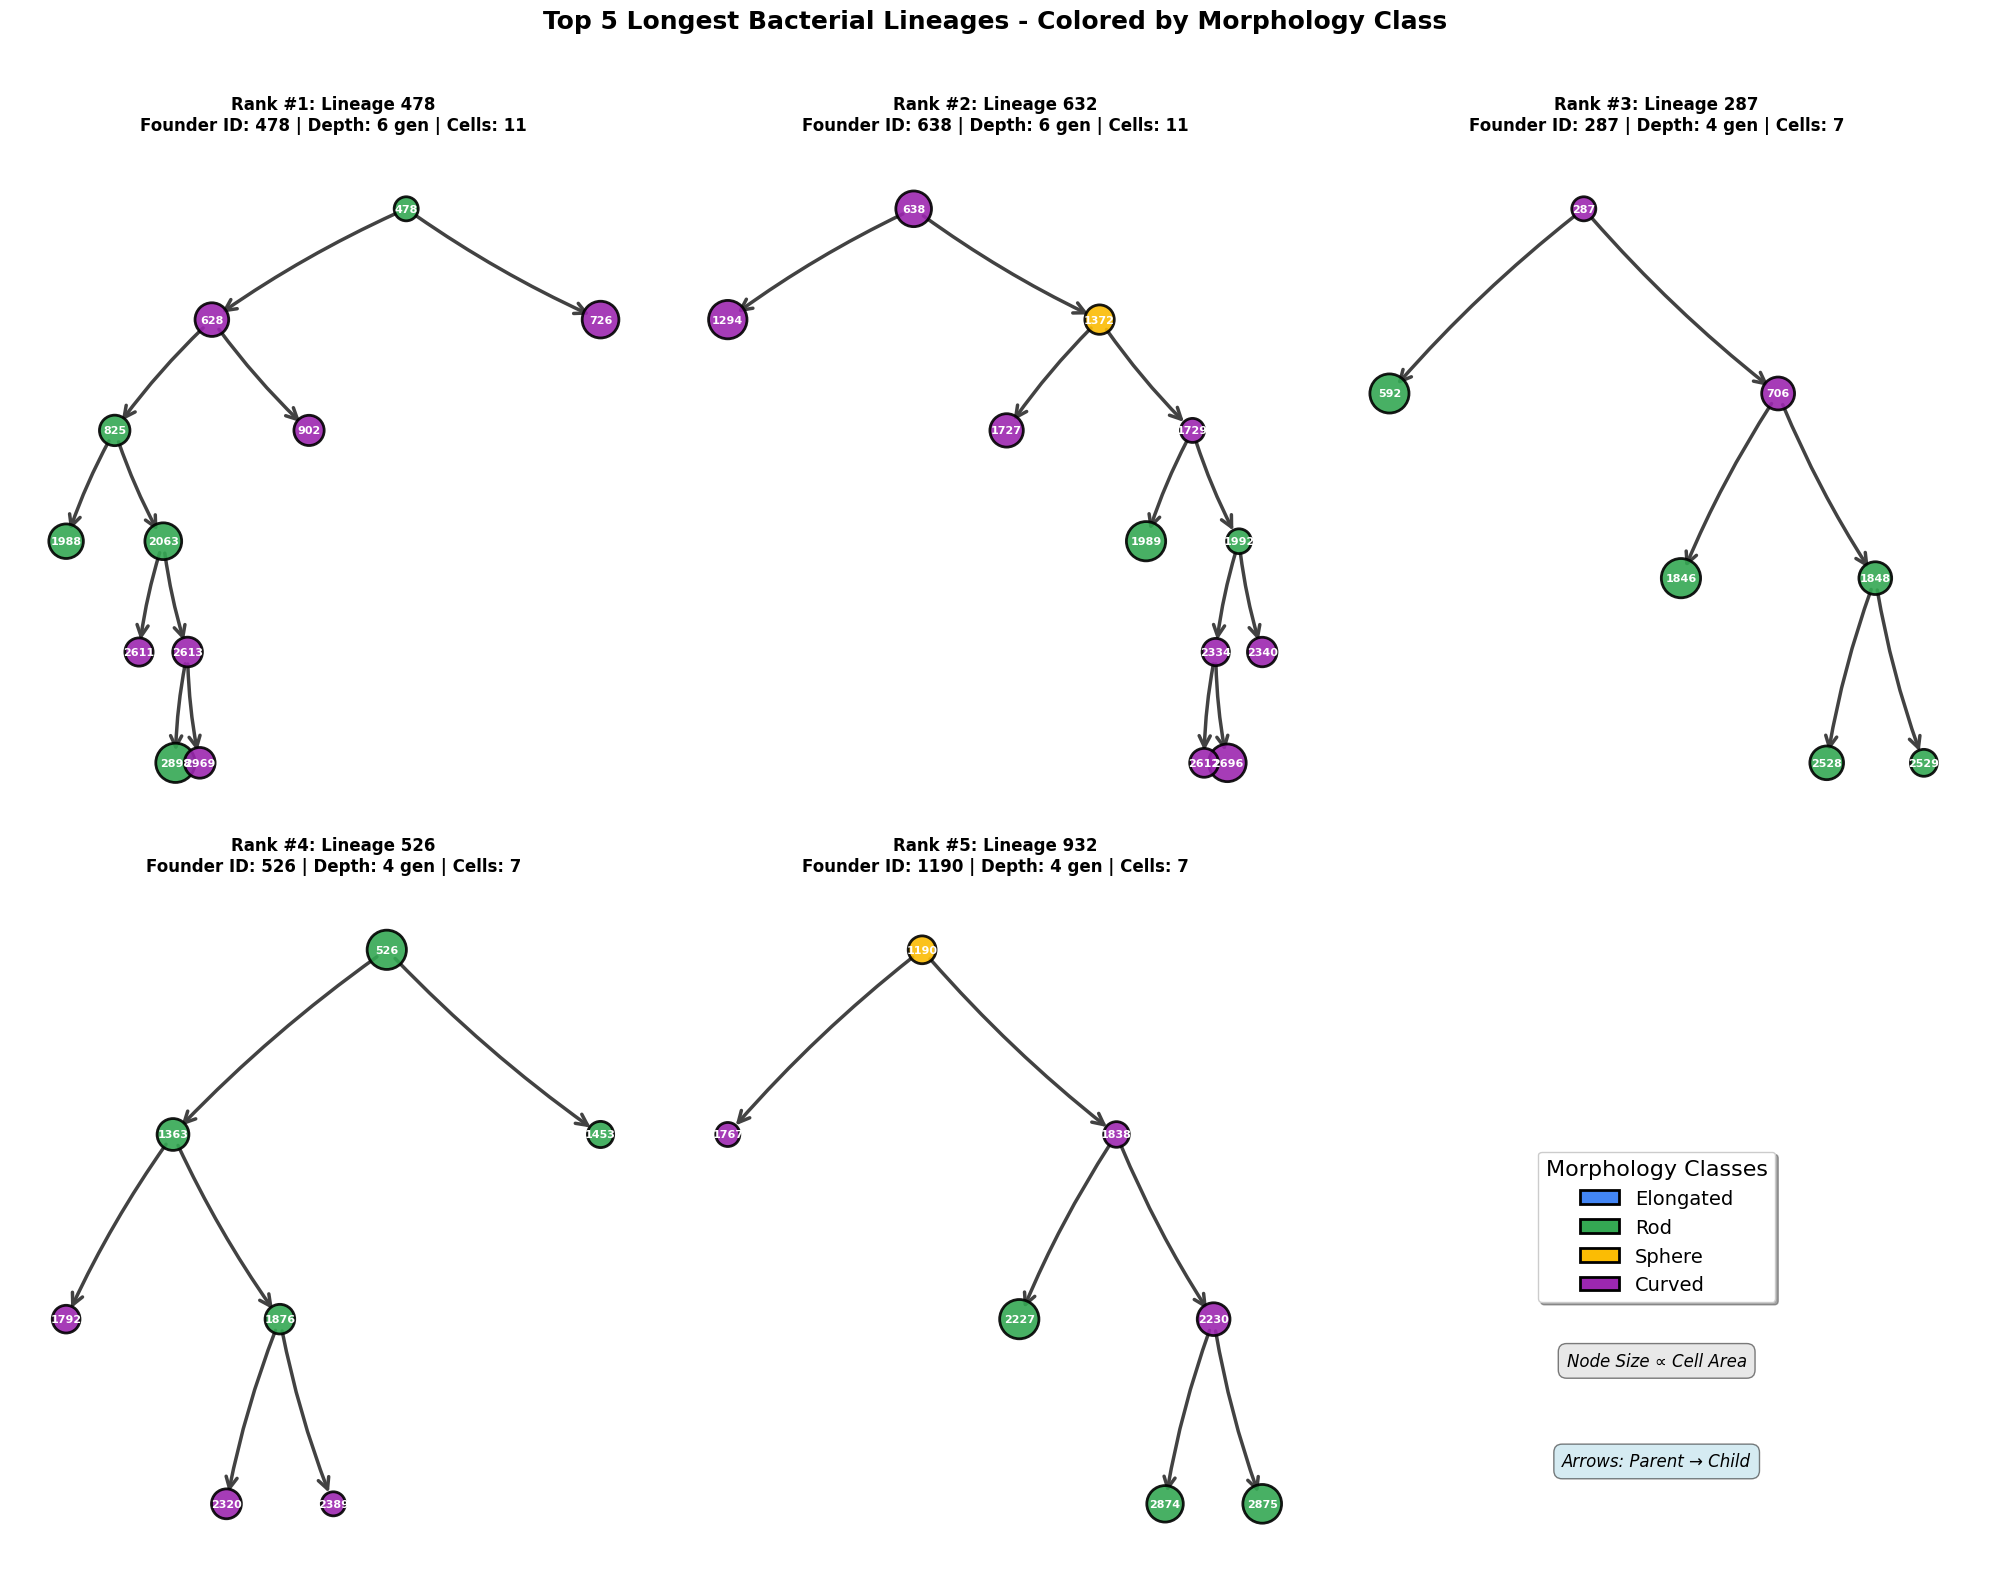


✓ Visualization complete!
   Created 5 lineage tree diagrams
   Color-coded by morphology class
   Node sizes scaled by cell area
   Saved to: top_5_lineages_morphology.png


In [5]:
# Part 4: Visualize Top 5 Lineages with Morphology Color-Coding

print("\n" + "="*60)
print("VISUALIZING TOP 5 LINEAGES")
print("="*60)

# Define morphology color mapping
MORPHOLOGY_COLORS = {
    'elongated': '#4285F4',  # Blue
    'rod': '#34A853',        # Green
    'sphere': '#FBBC04',     # Orange
    'curved': '#9C27B0'      # Purple
}

# Helper function for hierarchical tree layout
def hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    """
    Create hierarchical layout with root at top, children below.
    """
    def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0,
                      xcenter=0.5, pos=None, parent=None):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        
        children = list(G.successors(root))
        
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                    vert_loc=vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent=root)
        return pos
    
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

# Create figure with subplots for each of the top 5 lineages
fig = plt.figure(figsize=(20, 16), facecolor='white')

for i, (_, lineage_row) in enumerate(top_5_lineages.iterrows()):
    # Extract lineage info
    rank = lineage_row['rank']
    founder_id = lineage_row['founder_track_id']
    depth = lineage_row['depth_generations']
    total_cells = lineage_row['total_cells']
    lineage_cells = lineage_row['cells']
    
    print(f"\n🎨 Creating visualization for Rank #{rank} (Founder {founder_id})...")
    
    # Create subgraph for this lineage
    lineage_subgraph = G.subgraph(lineage_cells).copy()
    
    # Create subplot
    ax = plt.subplot(2, 3, i+1)
    
    # Try to use graphviz layout if available, otherwise use custom hierarchical layout
    try:
        pos = nx.nx_agraph.graphviz_layout(lineage_subgraph, prog='dot')
    except:
        # Fall back to custom hierarchical layout
        pos = hierarchy_pos(lineage_subgraph, founder_id, width=total_cells*0.3, vert_gap=0.15)
    
    # Prepare node colors based on morphology class
    node_colors = []
    for node in lineage_subgraph.nodes():
        morphology = lineage_subgraph.nodes[node]['morphology_class']
        node_colors.append(MORPHOLOGY_COLORS.get(morphology, '#999999'))
    
    # Prepare node sizes based on cell area
    node_sizes = []
    max_area = max(lineage_subgraph.nodes[node]['area'] for node in lineage_subgraph.nodes())
    min_area = min(lineage_subgraph.nodes[node]['area'] for node in lineage_subgraph.nodes())
    area_range = max_area - min_area if max_area > min_area else 1
    
    for node in lineage_subgraph.nodes():
        area = lineage_subgraph.nodes[node]['area']
        # Normalize area to size range 300-800
        normalized_size = 300 + ((area - min_area) / area_range) * 500
        node_sizes.append(normalized_size)
    
    # Draw nodes
    nx.draw_networkx_nodes(
        lineage_subgraph, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors='black',
        linewidths=2,
        alpha=0.9,
        ax=ax
    )
    
    # Draw edges with arrows
    nx.draw_networkx_edges(
        lineage_subgraph, pos,
        edge_color='#424242',
        width=2.5,
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.05',
        ax=ax
    )
    
    # Draw labels (track_id)
    nx.draw_networkx_labels(
        lineage_subgraph, pos,
        font_size=8,
        font_weight='bold',
        font_color='white',
        ax=ax
    )
    
    # Add generation level annotations
    # Calculate generation for each node
    generations = {}
    for node in lineage_subgraph.nodes():
        try:
            path_len = nx.shortest_path_length(lineage_subgraph, founder_id, node)
            generations[node] = path_len
        except:
            generations[node] = 0
    
    # Set title with lineage stats
    title = f"Rank #{rank}: Lineage {lineage_row['lineage_id']}\n"
    title += f"Founder ID: {founder_id} | Depth: {depth} gen | Cells: {total_cells}"
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
    
    ax.axis('off')

# Add overall legend for morphology classes
# Use the last subplot position for legend
legend_ax = plt.subplot(2, 3, 6)
legend_ax.axis('off')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=MORPHOLOGY_COLORS['elongated'], edgecolor='black', linewidth=2, label='Elongated'),
    Patch(facecolor=MORPHOLOGY_COLORS['rod'], edgecolor='black', linewidth=2, label='Rod'),
    Patch(facecolor=MORPHOLOGY_COLORS['sphere'], edgecolor='black', linewidth=2, label='Sphere'),
    Patch(facecolor=MORPHOLOGY_COLORS['curved'], edgecolor='black', linewidth=2, label='Curved')
]

legend_ax.legend(handles=legend_elements, loc='center', fontsize=14, 
                frameon=True, fancybox=True, shadow=True, title='Morphology Classes',
                title_fontsize=16)

# Add explanatory text
legend_ax.text(0.5, 0.3, 'Node Size ∝ Cell Area', 
              ha='center', va='center', fontsize=12, style='italic',
              bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.5))

legend_ax.text(0.5, 0.15, 'Arrows: Parent → Child', 
              ha='center', va='center', fontsize=12, style='italic',
              bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.5))

# Main title for entire figure
fig.suptitle('Top 5 Longest Bacterial Lineages - Colored by Morphology Class', 
            fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('top_5_lineages_morphology.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Visualization complete!")
print(f"   Created 5 lineage tree diagrams")
print(f"   Color-coded by morphology class")
print(f"   Node sizes scaled by cell area")
print(f"   Saved to: top_5_lineages_morphology.png")
print("="*60)

## Challenge 4 Summary

### 🎉 Congratulations! You've completed the Bacterial Lineage Analysis Challenge!

---

### What You Accomplished:

#### Part 1: Data Processing & Tree Construction (40%)
1. ✅ **Loaded and validated the dataset**
   - Read CSV file with 2,282 bacterial cells
   - Validated data integrity and column presence
   - Handled edge cases (orphaned cells, missing values)

2. ✅ **Built lineage tree structures**
   - Identified founder cells (parent_id == 0)
   - Constructed parent-child relationships using NetworkX directed graph
   - Created separate tree structures for each lineage

3. ✅ **Calculated lineage depth**
   - Computed number of generations for each lineage
   - Used graph traversal to find maximum path length from founder
   - Generation counting: founder = 1, founder→child = 2, etc.

4. ✅ **Identified the 5 longest lineages**
   - Ranked all lineages by depth (primary criterion)
   - Applied tiebreakers: total descendants → earliest founder track_id
   - Selected and reported top 5 lineages

#### Part 2: Visualization (30%)
5. ✅ **Created 5 separate tree visualizations**
   - Clear hierarchical layouts with founder at top
   - Nodes labeled with track_id
   - **Color-coded by morphology class:**
     - 🔵 Elongated = Blue
     - 🟢 Rod = Green
     - 🟠 Sphere = Orange
     - 🟣 Curved = Purple
   - Node sizes proportional to cell area
   - Generation levels clearly visible
   - Comprehensive legend and explanatory text
   - High-quality PNG export

---

### Key Metrics to Report:

**Dataset Statistics:**
- Total cells analyzed: 2,282
- Number of founder cells
- Number of separate lineages
- Frame range: 0-36

**Top 5 Lineages:**
- Founder track IDs
- Depth (generations) for each
- Total cells in each lineage
- Any tiebreakers applied

**Visualization Quality:**
- Morphology color distribution
- Hierarchical layout clarity
- Node size variation

---

### Grading Rubric:

| Component | Points | What to Check |
|-----------|--------|---------------|
| **Data Loading & Validation** | 10% | CSV loaded correctly, all validation checks passed |
| **Tree Construction** | 15% | Graph built correctly with all parent-child edges |
| **Depth Calculation** | 15% | Generations counted accurately for all lineages |
| **Ranking & Tiebreakers** | 10% | Top 5 identified correctly with proper tiebreaker logic |
| **Visualization Quality** | 20% | Clear, well-labeled trees with correct morphology colors |
| **Code Quality** | 10% | Clean, well-commented, efficient code |
| **Documentation** | 10% | Clear explanations and result interpretation |
| **Bonus Features** | 10% | Interactive viz, animations, creative layouts |

---

### Bonus Tasks (Extra Credit):

If you finished early and want to go further:

1. **Interactive Visualizations** ✨
   - Use plotly or pyvis for interactive tree exploration
   - Add hover tooltips with cell properties
   - Enable zoom and pan functionality

2. **Temporal Analysis** ⏰
   - Add frame information to nodes
   - Calculate cell division times
   - Analyze generation times (time between divisions)

3. **Advanced Coloring** 🎨
   - Dual encoding: morphology (color) + cell size (node size)
   - Gradient coloring by generation depth
   - Highlight longest path in each tree

4. **Export Options** 💾
   - Export to Newick format (phylogenetic tree standard)
   - JSON export for further analysis
   - Interactive HTML reports

5. **Statistical Analysis** 📊
   - Compare morphology distributions across lineages
   - Analyze correlation between morphology and division rate
   - Generate publication-ready summary statistics

---

### Tips for Presentation:

When presenting your results to the judges:

1. **Start with the big picture**: Total lineages, depth range
2. **Highlight the top 5**: Show the visualization prominently
3. **Explain your tiebreaker logic**: Demonstrate systematic thinking
4. **Discuss interesting patterns**: e.g., "Lineage 42 has mostly elongated cells"
5. **Show code quality**: Well-structured, commented, efficient

---

### Common Pitfalls to Avoid:

- ❌ Counting edges instead of nodes for generations (off by 1 error)
- ❌ Forgetting to handle orphaned cells (invalid parent_ids)
- ❌ Using total cell count instead of depth for ranking
- ❌ Not applying tiebreakers in the specified order
- ❌ Illegible visualizations (too small fonts, overlapping nodes)

---

### Resources & Libraries Used:

- **pandas**: Data loading and manipulation
- **networkx**: Graph construction and traversal
- **matplotlib**: Static visualizations
- **numpy**: Numerical operations
- Optional: **plotly**, **pygraphviz** for advanced viz

---

**Great work on completing this challenge! Your lineage analysis will help researchers understand bacterial cell division dynamics and morphological changes across generations. 🔬🦠**

---